# <font color='blue'>**Welcome to the INCEPTION injector.**  </font>

- This is a python3 tool designed to inject binary-pulsar signals into real filterbank data.
- This tutorial will briefly explain how to use the injector and the currently implemented features.

### <font color='green'>Two modes:</font>
- python (recommended)
- pint (generate, or supply polycos)


### <font color='green'>Required packages:</font> 
- numpy
- scipy 
- astropy
- sympy
- pandas

### <font color='green'>Optional packages:</font>
- jplephem
    - required if using a jpl ephemeris (recommended)
    - astropy default uses epv00 and plan94 routines from ERFA (not as precise)
    - get .bsp files from https://ssd.jpl.nasa.gov/ftp/eph/planets/bsp/

- pint-pulsar
    - only required if you want injection to be done using polycos

#### <font color='green'> Command line:</font> 
- first three inputs are required
- example SLURM script is available

<code> python3 SCRIPT_inject_pulsars.py --signal=path/example.inject --filterbank=path/filterbank.fil --output=dir_path --ephem=path/de440.bsp --ncpu=48 </code>

- --signal 
    - file containing parameters for each pulsar to inject
- --filterbank 
    - SIGPROC filterbank to inject into (currently supports 8bit data) 
- --output 
    - output directory for injected filterbank and a TEMPO style par file for each pulsar in --signal
- --ephem  
    - (optional, default astropy 'builtin') 
    - jpl ephemeris file used for topocentric to barycenteric conversions
- --ncpu 
    - (optional, default 1)
    - number of cpus to use for injection (injection is parallelised across time)



In [ ]:
# example.inject (isolated pulsar)
# ID               pulsar1        # added to name of injected filterbank (filterbank.fil -> filterbank_pulsar1.fil), also name of outputed par file (pulsar1.par)
# mode             python         
# PEPOCH           59379.1234     # (mjd, tdb, barycentre) removing will default to observation start
# RAJ	             17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0072973525   # (sec) Will accept PX or FX for any spin parameter
# F1               6.67430e-11
# F2               1e-12
# F6               2e-13          # can supply inf FX, any missing FX will be set to zero
# SNR              42
# DM               29.9792458
# duty_cycle       0.08           # default gaussian profile
# phase_offset     0      

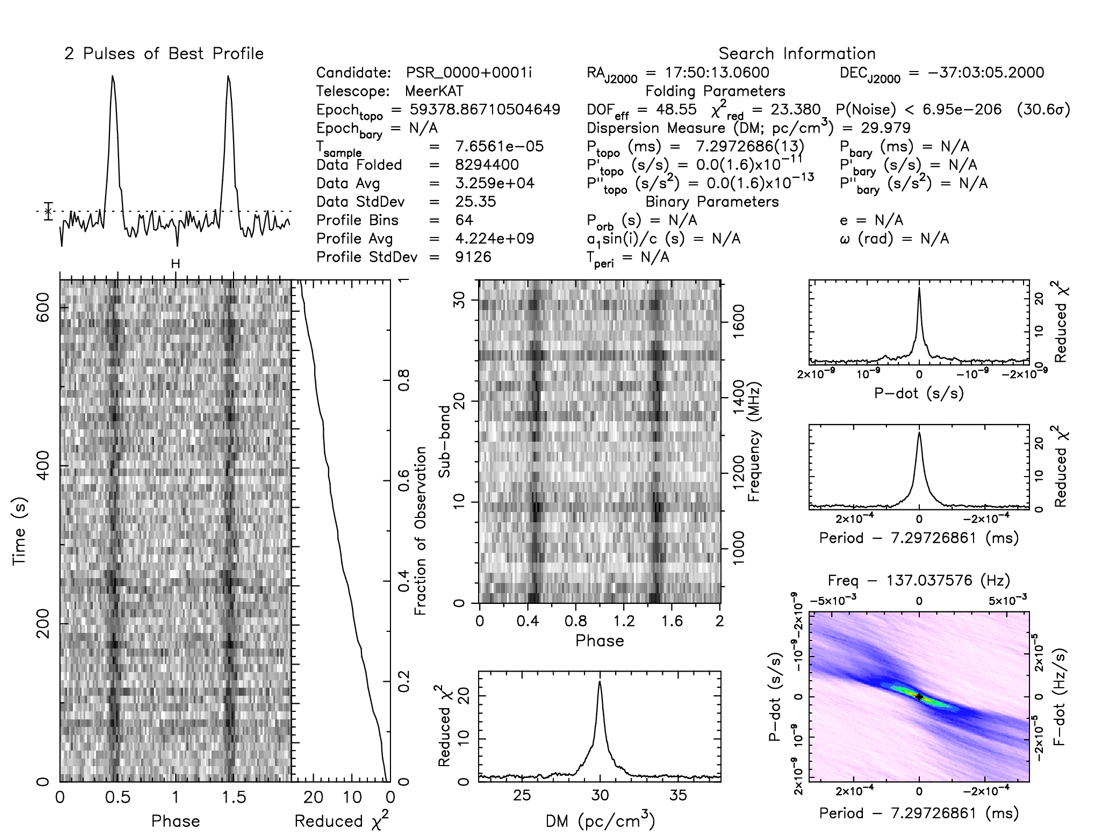

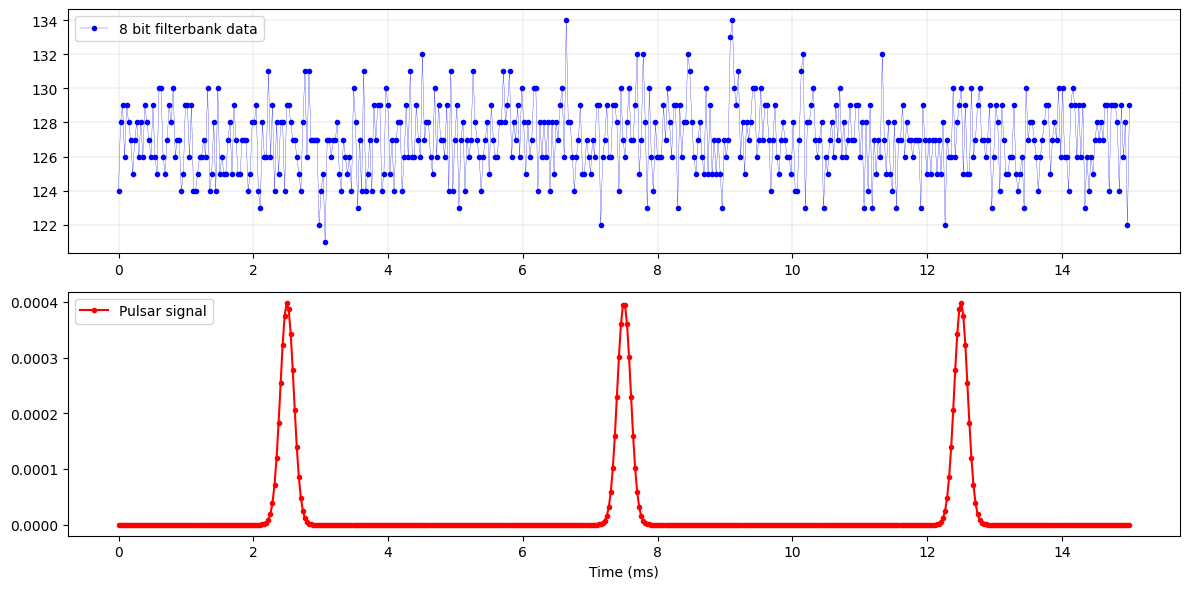

In [113]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(100)
time_series = np.linspace(0, 15, 500)
pulse_train = norm(2.5, 0.1).pdf(time_series%5) * 1e-4
f_data = np.round(np.random.normal(127, 2, size=500))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=2)
ax1.plot(time_series, f_data, 'b.-', lw=0.2, label='8 bit filterbank data')
ax2.plot(time_series, pulse_train, 'r.-', label='Pulsar signal')
ax2.set_xlabel('Time (ms)')
ax1.legend(loc=2)
ax1.grid(lw=0.2)
ax2.legend(loc=2)
plt.tight_layout()

Text(0.5, 0, 'Filterbank data')

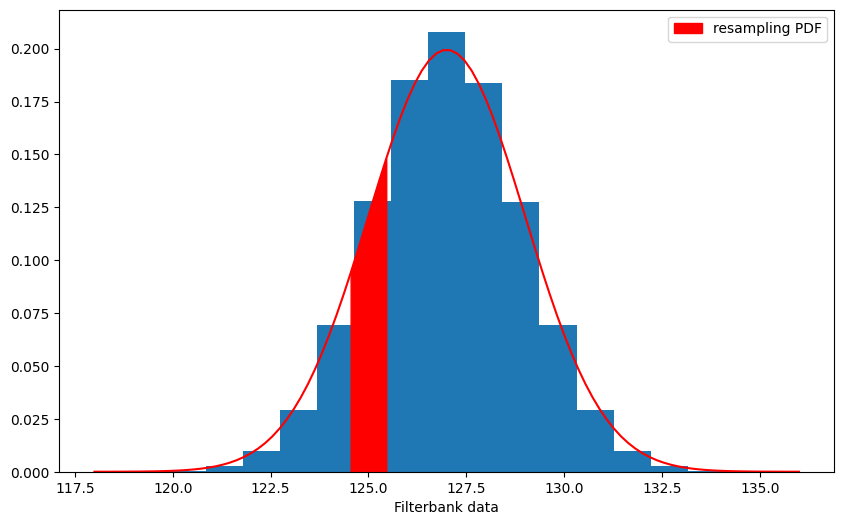

In [121]:
np.random.seed(101)
fb_data = np.round(np.random.normal(127, 2, size=10**6))
pdf_range = np.linspace(fb_data.min(), fb_data.max(), 100)
samples = np.where((pdf_range>124.5) & (pdf_range<125.5))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(fb_data.flatten(), bins=19, density=True)
ax.plot(pdf_range, norm(127, 2).pdf(pdf_range), 'r-')
ax.fill_between(pdf_range[samples], norm(127, 2).pdf(pdf_range)[samples], color='red', label='resampling PDF')
ax.legend()
ax.set_xlabel('Filterbank data')

In [ ]:
# resampling example: 
#     8bit filterbank value --> resampled filterbank value + pulsar signal = new filterbank value --> new 8bit filterbank value
#            125            -->          125.499           +      0.001    =         125.5        -->           126

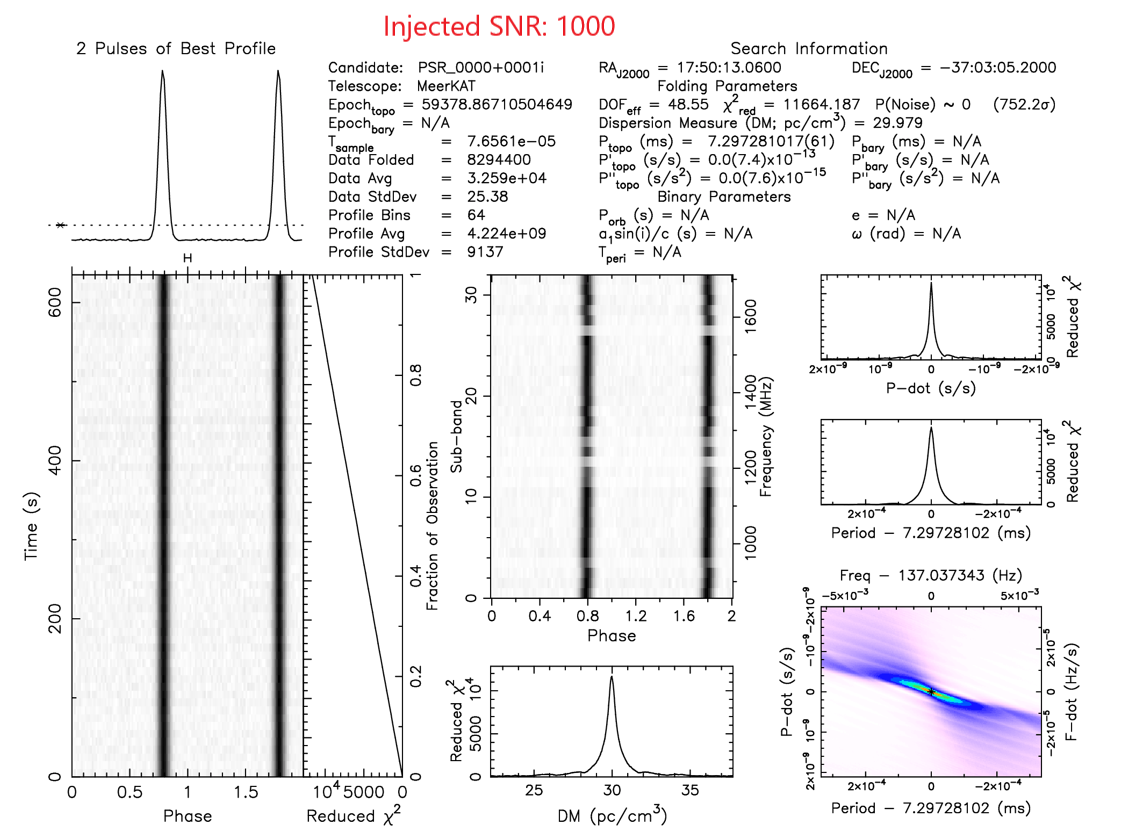

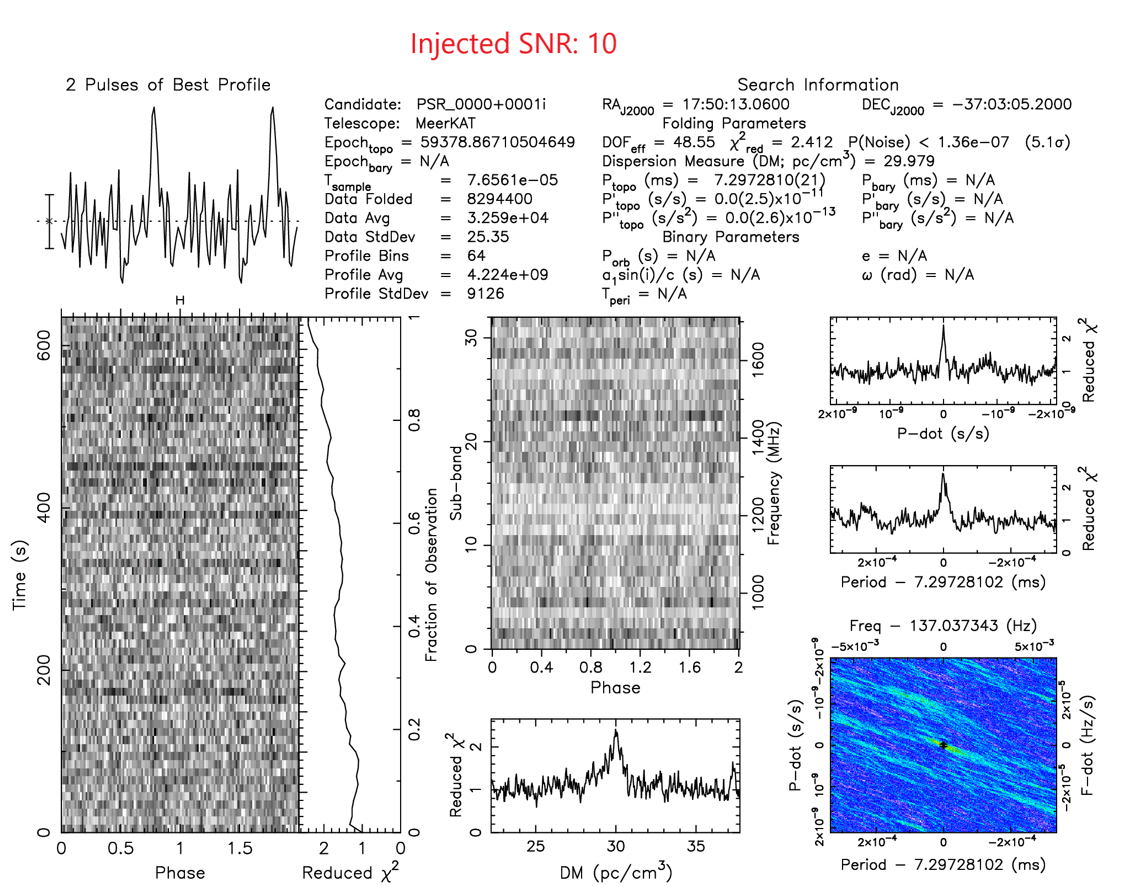

In [ ]:
# If you are injecting multiple pulsars into the same filterbank, you must inject them all at the same time. (Will be much faster)
# Resampling statistics won't be correct if you loop the injection instead.
# 
# Inject pulsar position using either (RA, DEC) or (separation, positional angle) relative to beam-axis (positive angles East of North).
# Offset positions from beam axis will reduce the injected SNR using a gaussian with FWHM equal to beam_fwhm
# 
# example.inject (multi pulsar inject)
# ID               pulsar1        
# mode             python         
# PEPOCH           59379.1234     
# RAJ	             17:50:13.0600      # Not inputing a RA and DEC will result in the pulsar being injected on the beam axis
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12       
# SNR              42
# DM               29.9792458
# duty_cycle       0.08
# 
# ID               pulsar2            # the injector code searches for ID flags to inject multiple pulsars     
# mode             pint   
# pint_N           12                 # N coeff
# pint_T           5                  # min    (1 min minimum)
# PEPOCH           59379.1234     
# separation       4                  # (arcmin)
# position_angle   35                 # (deg)
# beam_fwhm        10                 # (arcmin) SNR will only be reduced if a beam_fwhm is given
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12       
# SNR              42
# DM               29.9792458
# duty_cycle       0.08

In [ ]:
# example.inject (custom pulse profile)
# ID               pulsar1        
# mode             python         
# PEPOCH           59379.1234     
# RAJ	           17:50:13.0600   
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12       
# SNR              100
# DM               29.9792458
# profile          pulse_profile.npy      # file name of numpy .npy (the injector code will normalise the profile)

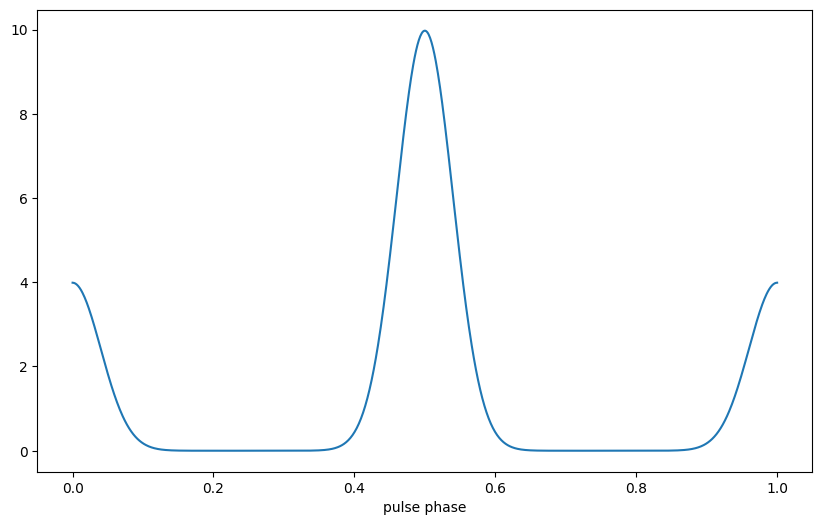

In [132]:
phase = np.linspace(0, 1, 1000)
profile = norm(0.5, 0.04).pdf(phase)
profile += norm(0, 0.04).pdf(phase)*0.4
profile += norm(1, 0.04).pdf(phase)*0.4
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(phase, profile)
ax.set_xlabel('pulse phase')

np.save('pulse_profile', profile)

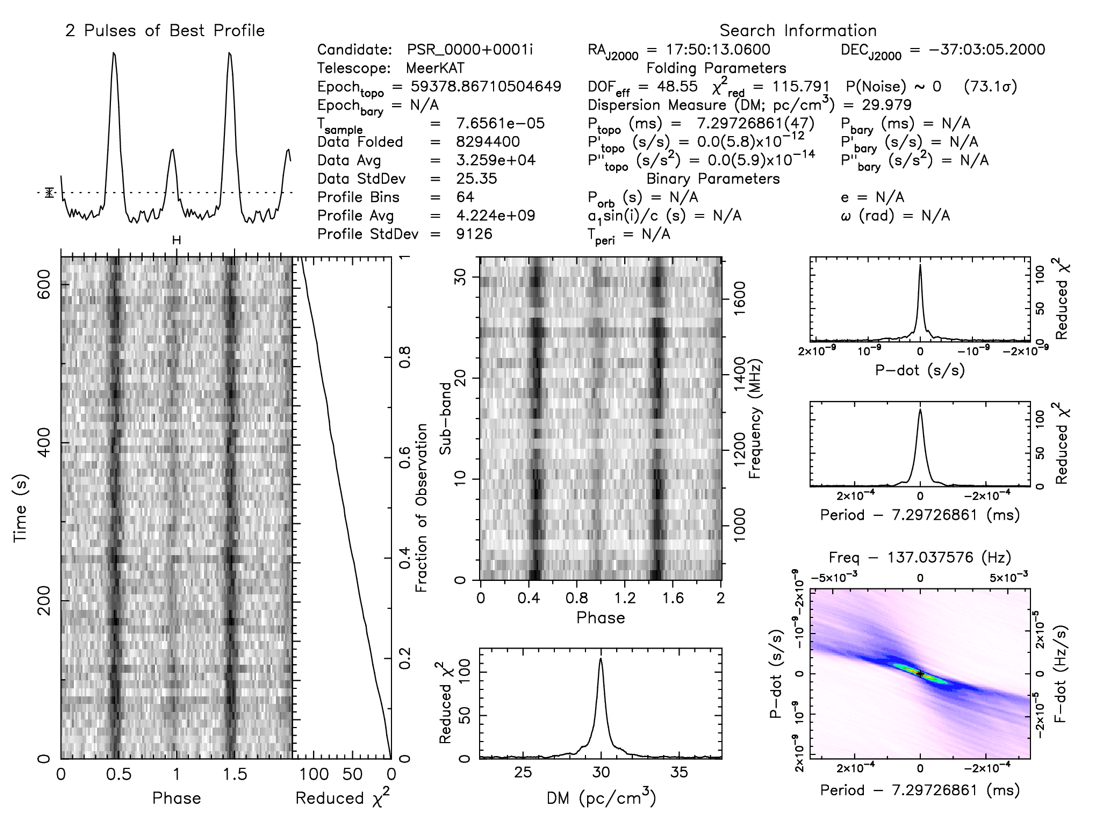

In [ ]:
# example.inject (pulse profile (I) from EPN database https://psrweb.jb.man.ac.uk/epndb/)
# ID               pulsar1        
# mode             python         
# PEPOCH           59379.1234     
# RAJ              17:50:13.0600   
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12       
# SNR              200                                 
# DM               29.9792458
# duty_cycle       0.01                                # put in approx duty_cycle to get a close SNR (will fix soon)
# profile          J0051+0423_L85600_HBA.prof.txt      # file name of .txt EPN profile (the injector code will normalise the profile)

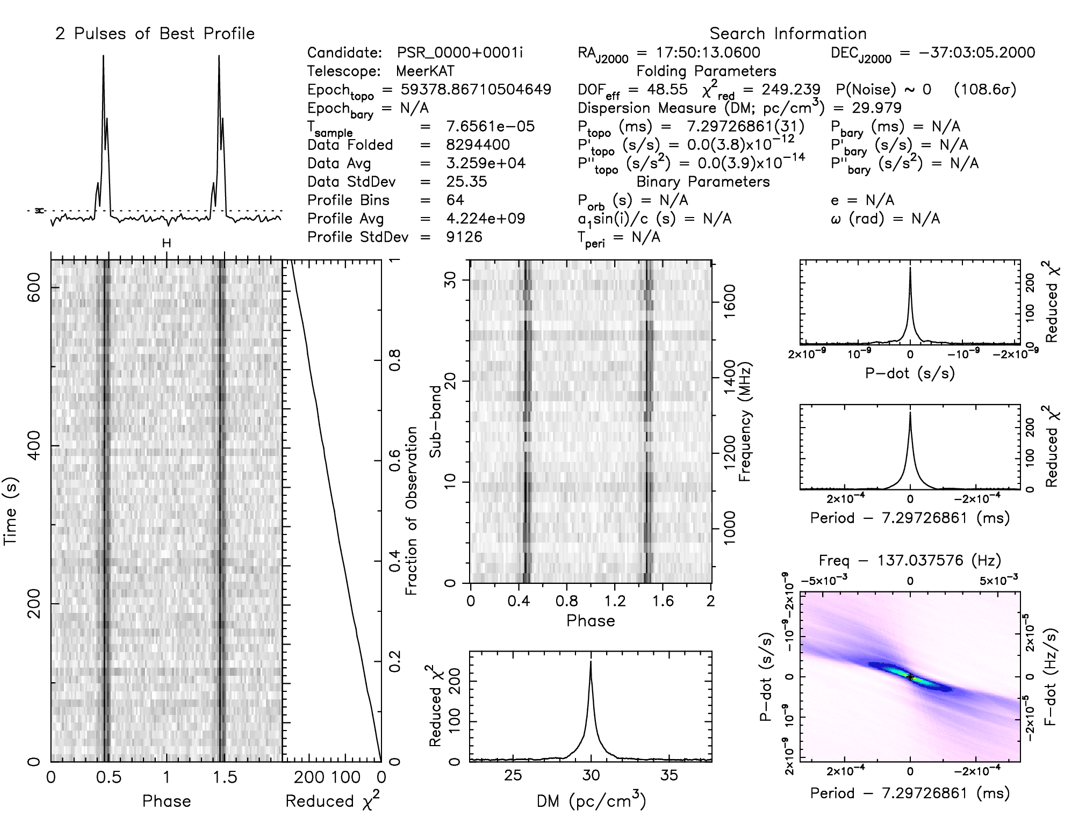

In [ ]:
# example.inject (scattering)
# ID               pulsar1        
# mode             python         
# PEPOCH           59379.1234     
# RAJ	             17:50:13.0600   
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12       
# SNR              200
# DM               29.9792458
# scattering_time  inf                 # inf equals no scattering
# profile          pulse_profile.npy

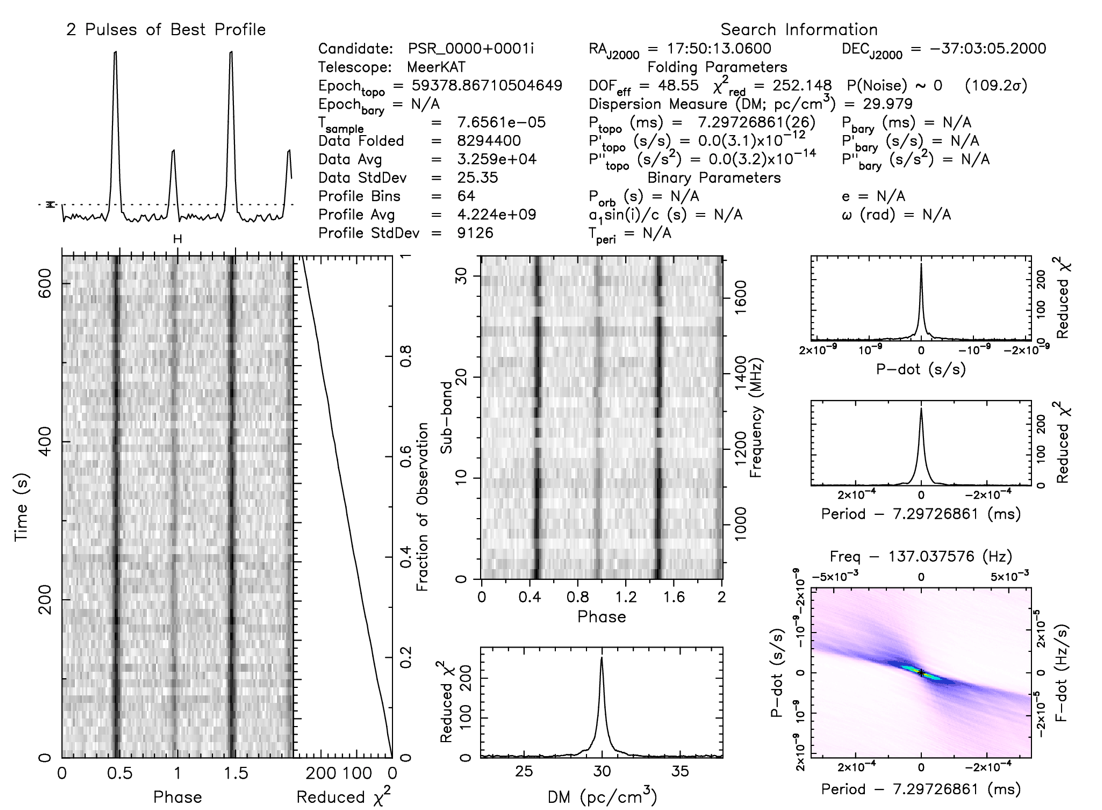

In [ ]:
# scattering_time         60 (first plot)
# scattering_time         15 (second plot)
 
# Pulse profile is numerically convolved with exp(-scattering_time * t)  
# Currently scattering_time is equal to ~ pulse period/T_s  
# Profile is normalised before scattering, which therefore reduces the SNR
# (No dependency on frequency, will be fixed soon)

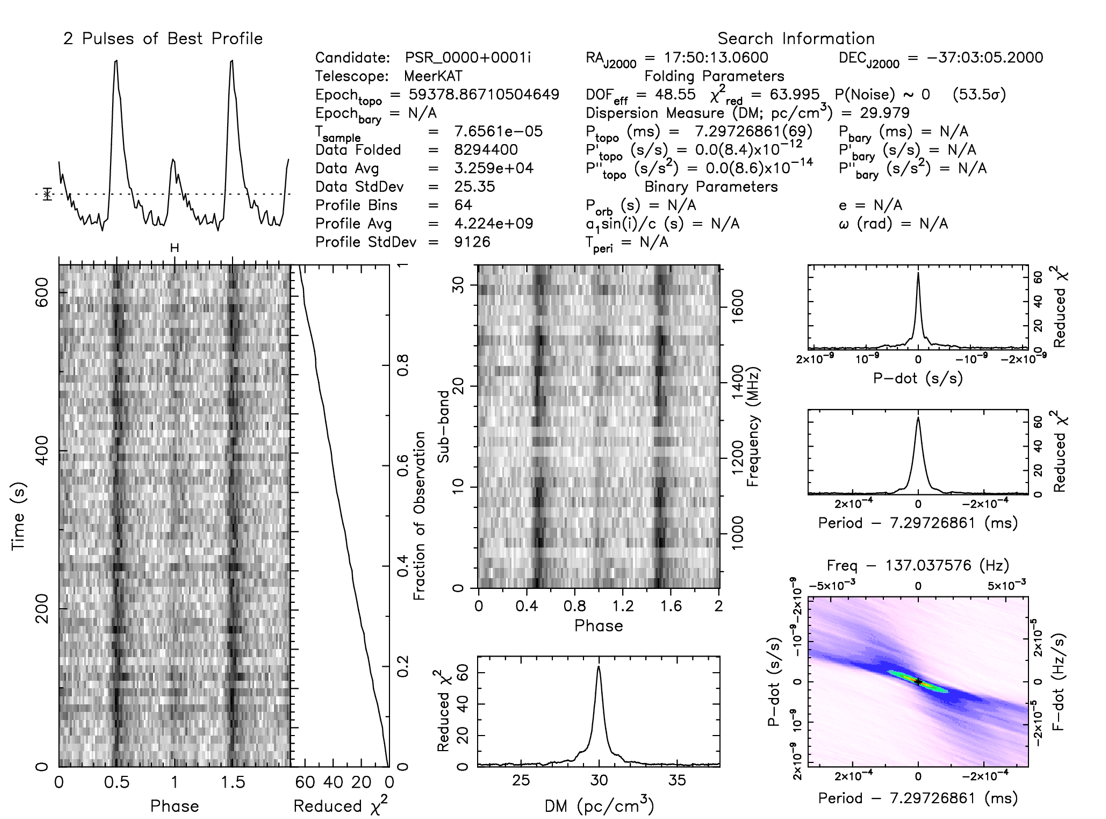

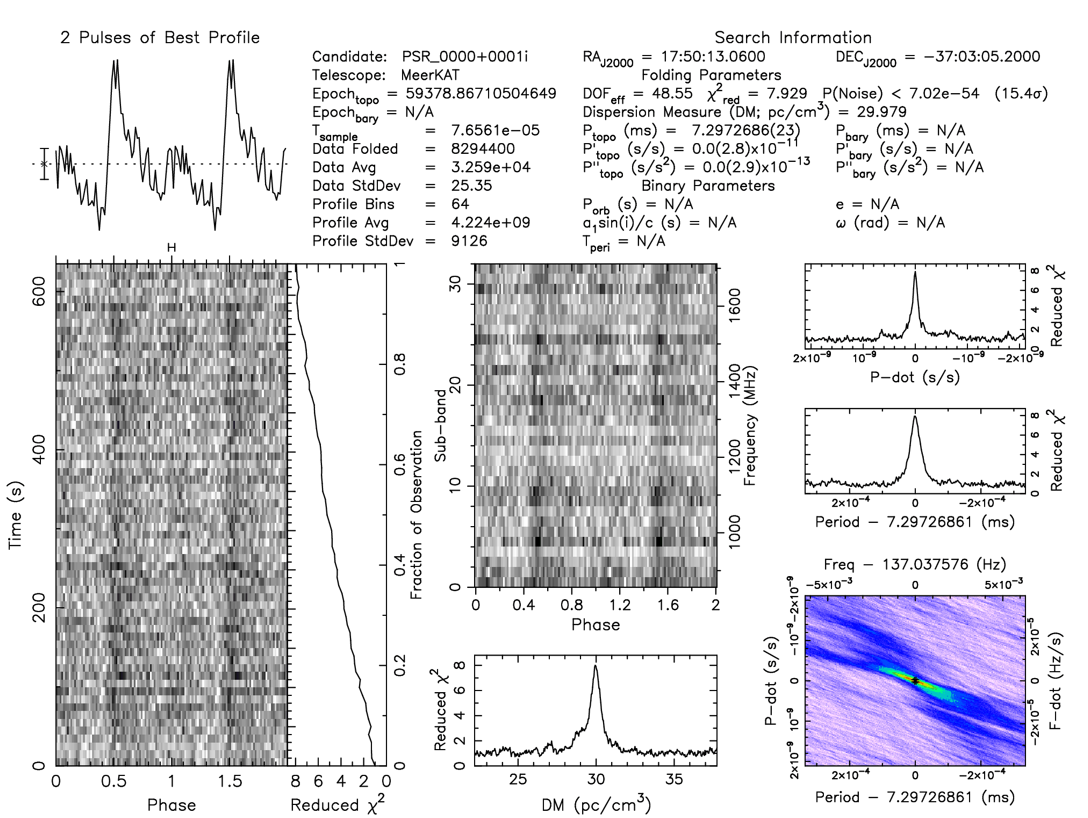

In [ ]:
# Only BT model is currently implemented in python mode (Blandford & Teukolsky 1976)
# pint mode has BT, DD, DDGR, ELL1, ... many more, but only BT model is set up to work in the injector (for now)
# 
# example.inject (binary)
# ID               pulsar1
# mode             python
# PEPOCH           59379
# RAJ              17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12  
# SNR              200
# DM               29.9792458
# profile          pulse_profile.npy
# binary_period    6                  # hour
# T0               59379.123          # (mjd, tdb, barycentric) defaults to observation start
# A1               2.1                # A1 or M1, M2, inc
# ecc              0.2
# AoP              0.0                # argument of periapsis (deg)
# LoAN             0.0                # (default 0 deg) TEMPO: OM = AoP + LoAN
# 
# ID               pulsar2
# mode             python
# PEPOCH           59379
# RAJ              17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12  
# SNR              200
# DM               29.9792458
# profile          pulse_profile.npy
# binary_period    6                  # hour
# T0               59379.123
# M1               1.4                # pulsar mass
# M2               2                  # companion mass
# inc              90.0               # (deg) 90 -> edge on
# ecc              0.2
# AoP              0.0

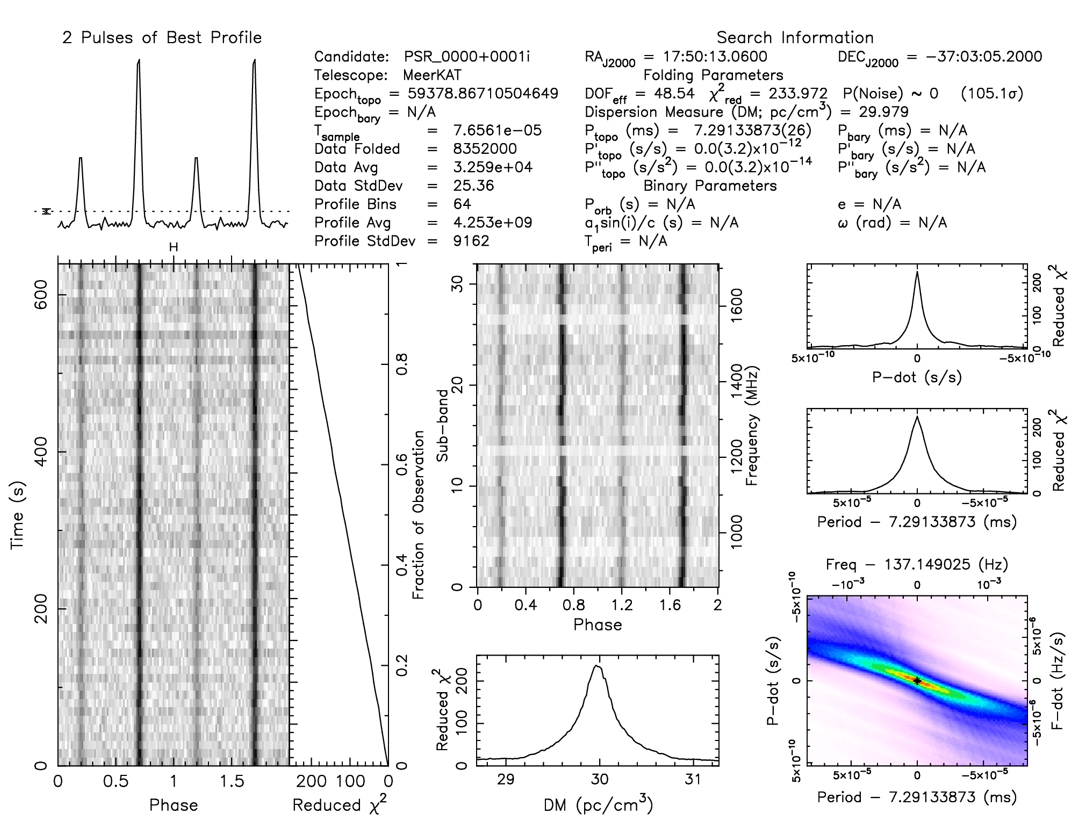

In [ ]:
# example.inject (fast binary)
# ID               test1
# mode             python
# PEPOCH           59379
# RAJ              17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0072973525  
# F1               6.67430e-11
# F2               1e-12  
# SNR              200
# DM               29.9792458
# profile          pulse_profile.npy
# binary_period    1                  # hour
# T0               59379.123
# M1               1
# M2               1
# inc              90 
# ecc              0.2
# AoP              0.0

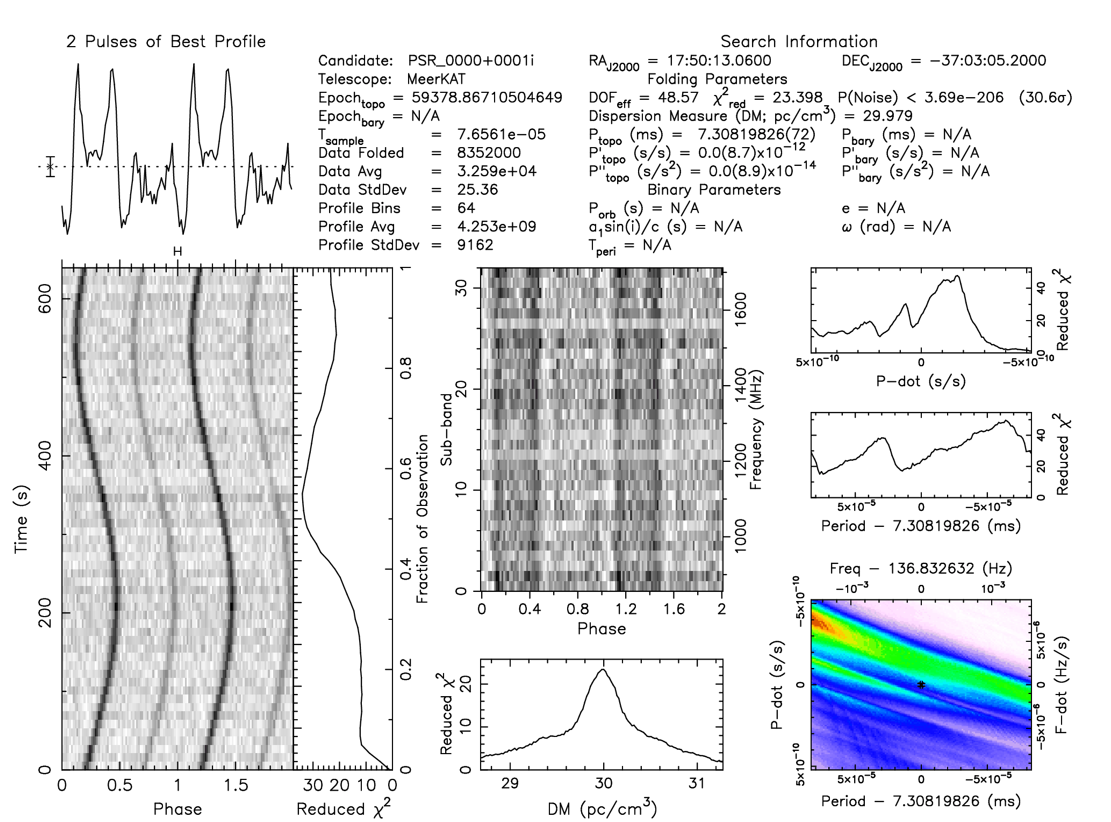

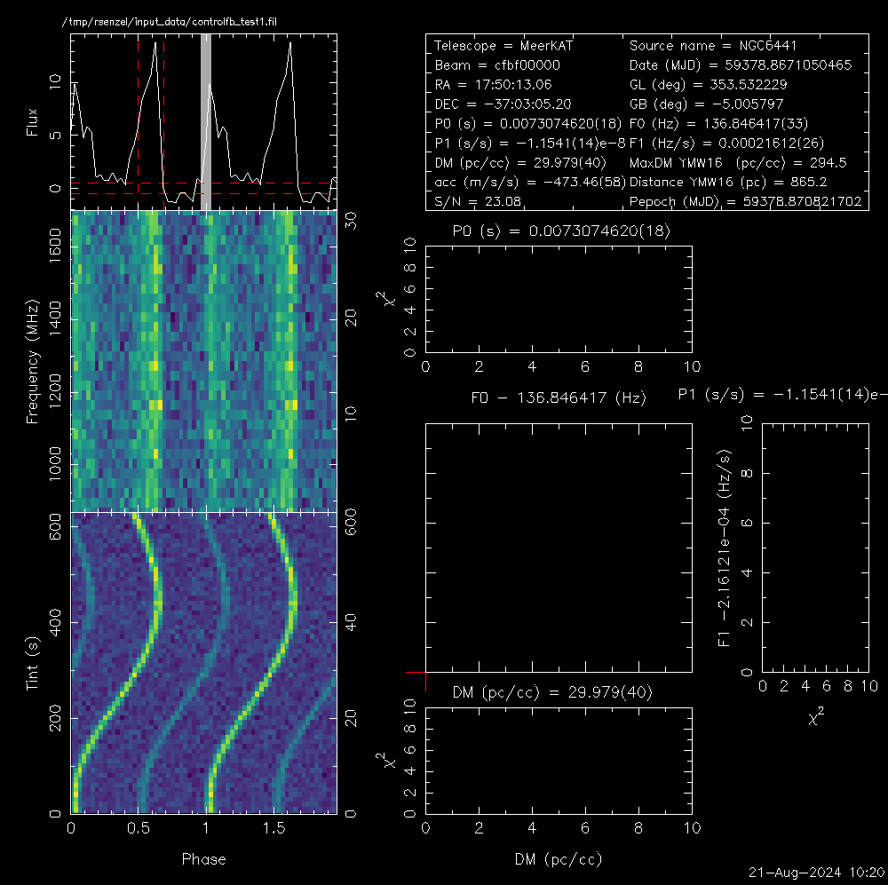

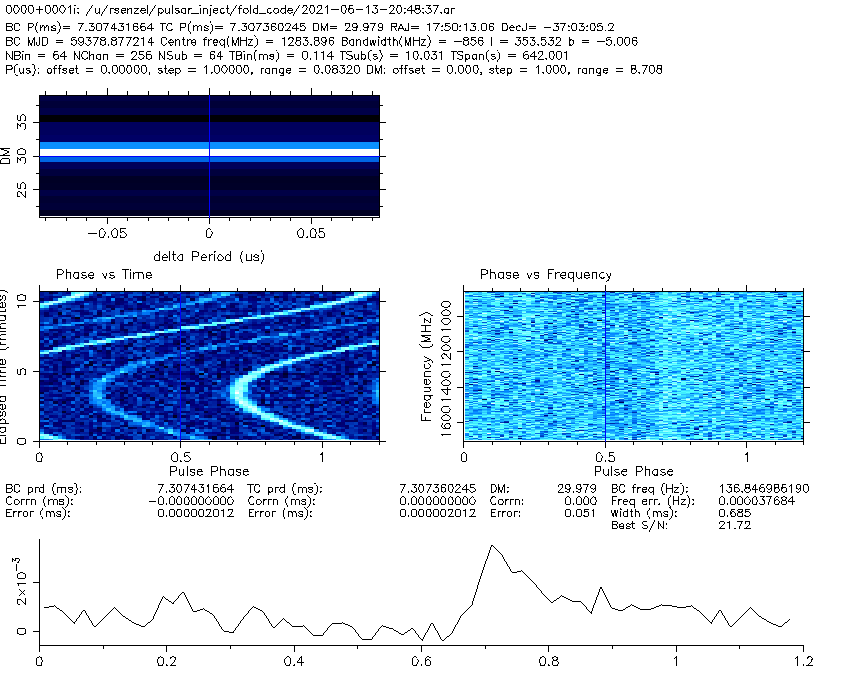

In [ ]:
# Default folding by presto, pulsarx and (dspsr?) uses 12 coeff for 60 minutes. Insufficient for fast binary pulsars. 
# 
# Create a tempo2 predictor with 12 coeff for 60 seconds.
#     tempo2 -f pulsar1.par -pred "meerkat mjd_start mjd_end freq_start freq_end 12 12 60"
# 
# pass into dspsr using -P t2pred.dat
# pass into pulsarx using --t2pred t2pred.dat   (default 12 coeff, 3600 seconds)

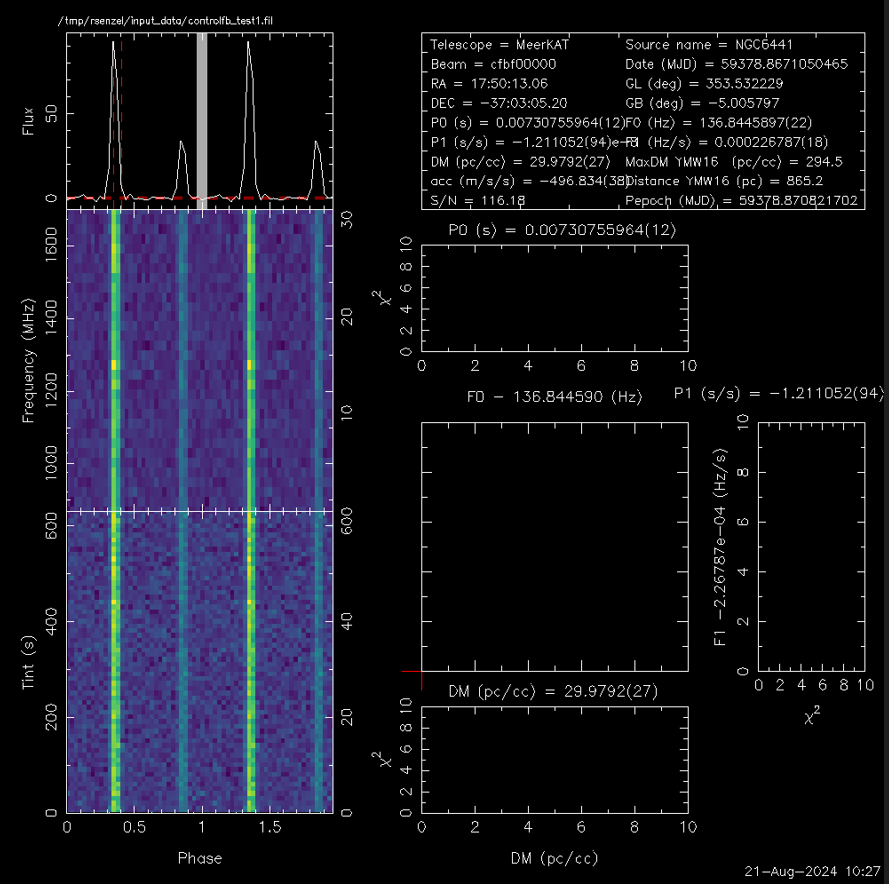

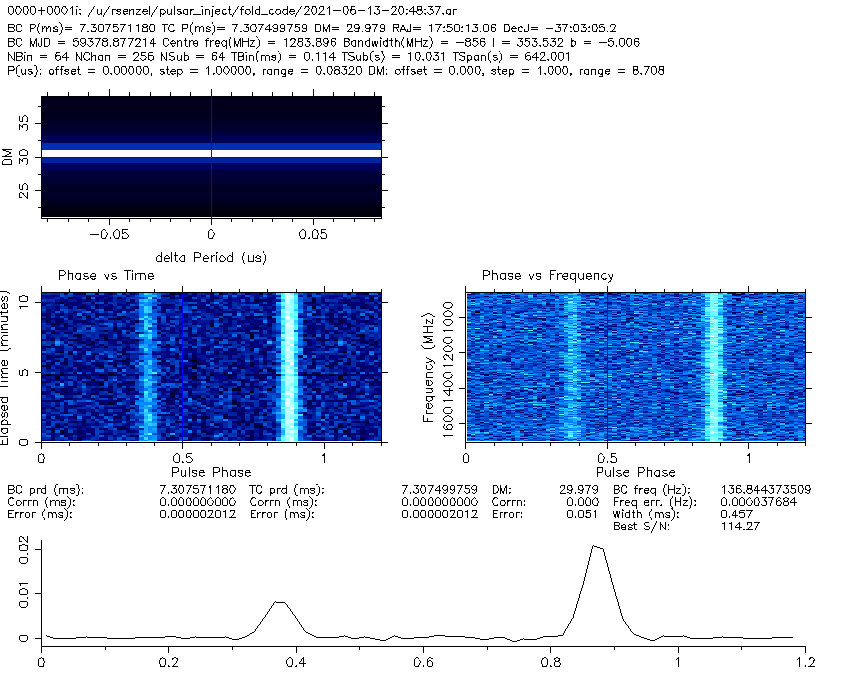

In [ ]:
# example.inject (6 min, T0 -> obs start)
# ID               pulsar1
# mode             python
# PEPOCH           59379
# RAJ              17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0072973525   
# SNR              200
# DM               29.9792458
# profile          pulse_profile.npy
# binary_period    0.1                # hour
# M1               1                  # A1: 0.1593
# M2               1
# inc              90   
# ecc              0.3
# AoP              0.0
# 
# (used same t2pred with 12 coeff in 2 seconds for pulsarx and dspsr plots below)

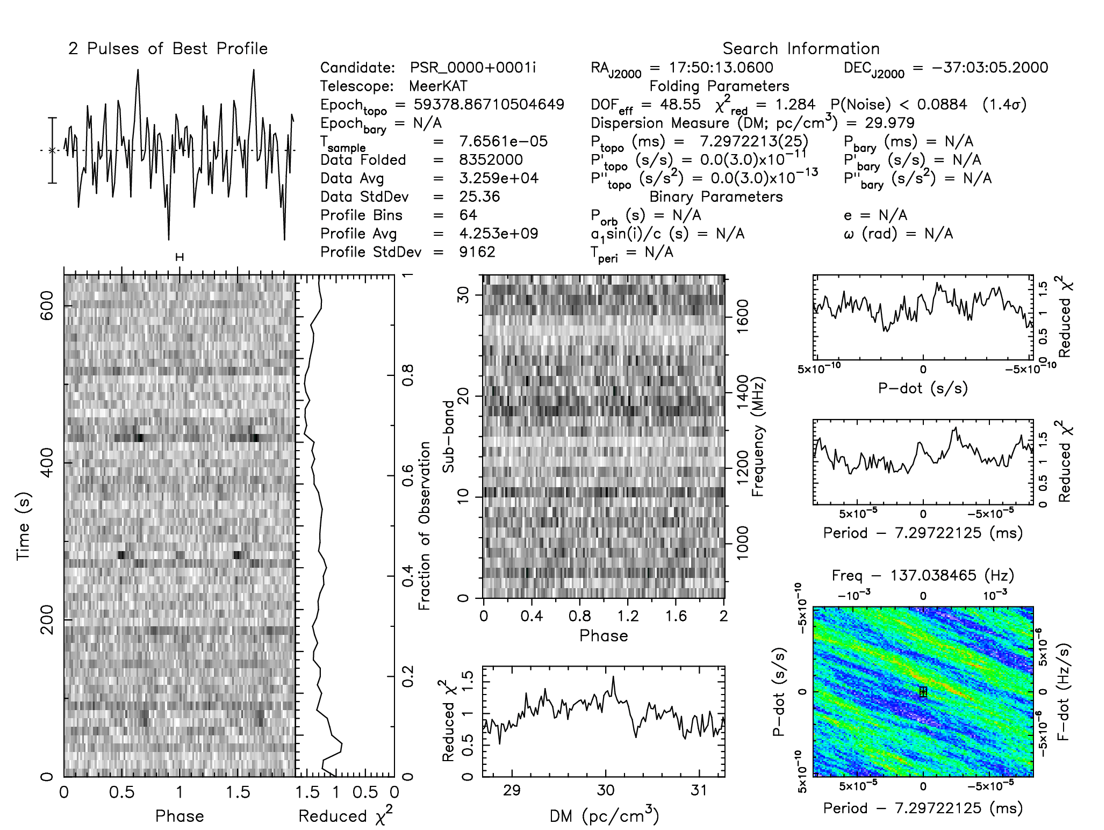

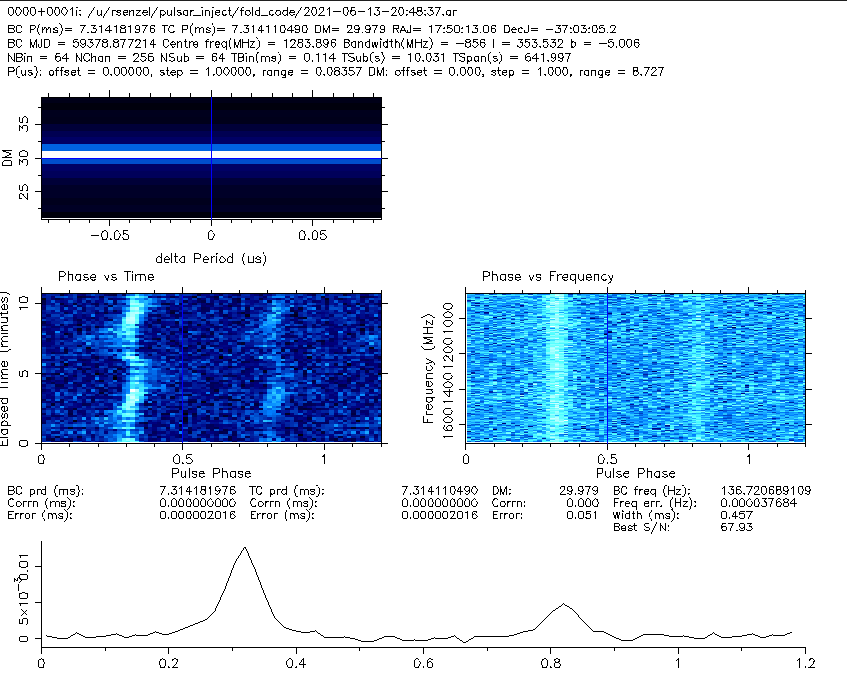

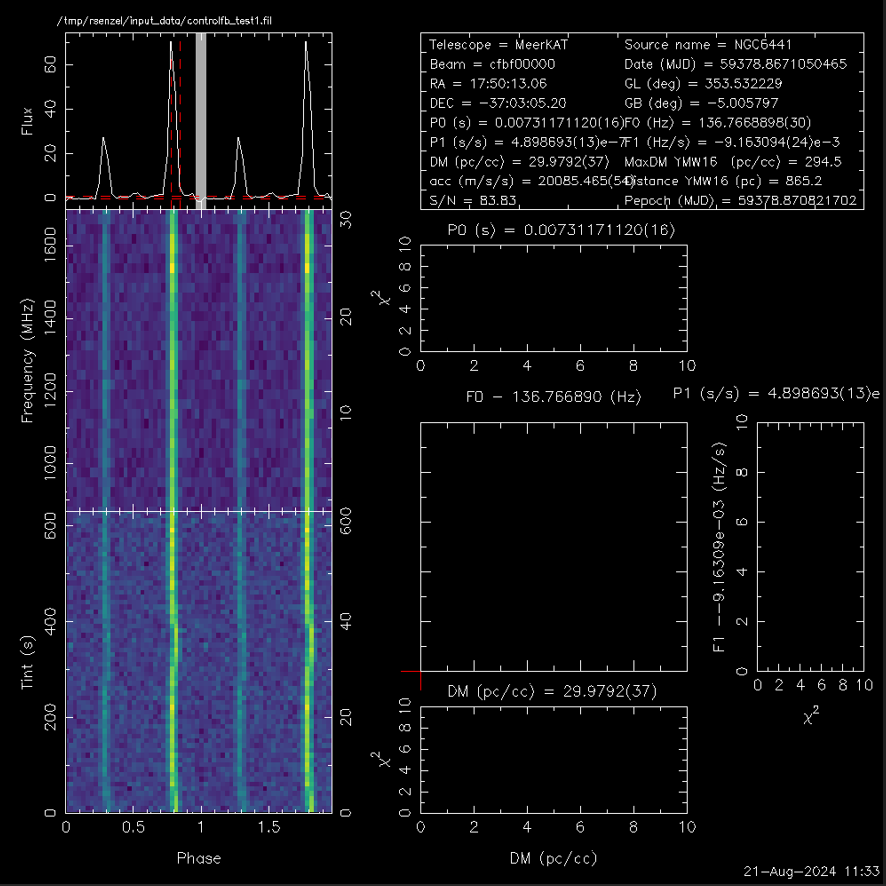

In [ ]:
# example.inject (sub-millisecond)
# ID               pulsar1
# mode             python
# PEPOCH           59379
# RAJ              17:50:13.0600
# DECJ             -37:03:05.2000
# P0               0.0009  
# F1               1e-13
# SNR              200
# DM               29.9792458
# profile          pulse_profile.npy
# binary_period    6                # hour
# T0               59378.123
# M1               1
# M2               1
# inc              90   
# ecc              0.0
# AoP              0.0

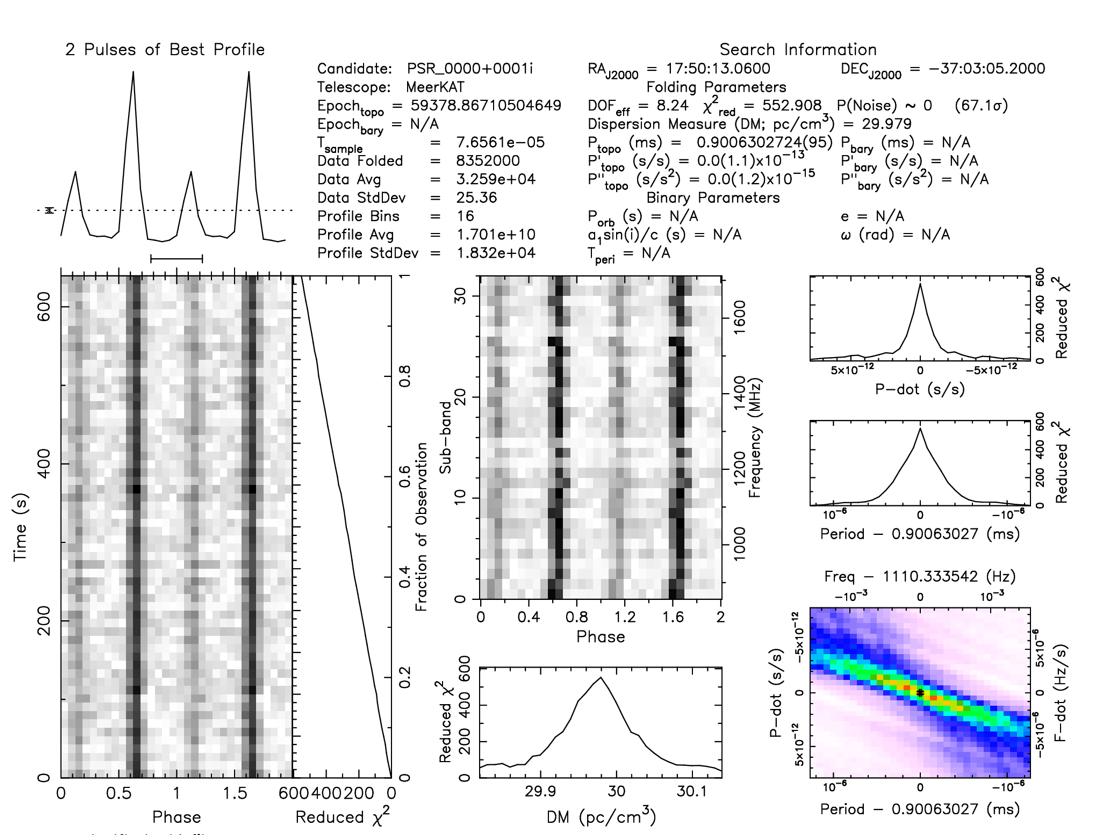

### <font color='green'>TODO:</font>
- frequency dependence for scattering
- PMRA, PMDEC, px
- scintillation
- omega_dot, p_dot, pb_dot + other binary models
- mask in time/frequency